### CAPTURE SATELLITE IMAGES FOR PRESENT PERIOD (2017 - 2022)

In [1]:
import ee
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from datetime import date
import json
from json import JSONEncoder

Authentification auprès de Google Engine :

Cliquer sur le lien et suivre les instructions (avec compte google connecté) pour récupérer le token à copier-coller.

In [2]:
ee.Authenticate()
ee.Initialize()
print(ee.Image("NASA/NASADEM_HGT/001").get("title").getInfo())


Successfully saved authorization token.
NASADEM: NASA NASADEM Digital Elevation 30m


-----------

CLASS FOR EXCEPTIONS :

In [25]:
class NoImage(Exception):
    def __init__(self, nb_image):
        self.__nb_image = nb_image

    @property
    def nb_image(self):
        return self.__nb_image

In [4]:
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, (datetime, date)):
            return str(obj)
        return json.JSONEncoder.default(self, obj)

FUNCTIONS (FOR SENTINEL_2):

In [5]:
def NDVI(img): #repère la végétation tout simplement
    img = ee.Image(img.normalizedDifference(['B8', 'B4'])).rename(["ndvi"])
    return img

def EVI(img): #idem NDVI, plus fiable et fin en théorie
    img = ee.Image(img.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
            'NIR': img.select('B8').divide(10000),
            'RED': img.select('B4').divide(10000),
            'BLUE': img.select('B2').divide(10000)
        })).rename(["evi"])
    
    return img

def NDMI(img): #repère la teneur en eau dans la végétation
    #img = ee.Image(img.normalizedDifference(['B8', 'B11'])).rename(["ndmi"])
    img = ee.Image(img.expression(
        '(NIR - SWITCH) / (SWITCH + NIR)', {
            'NIR': img.select('B8').divide(10000),
            'SWITCH': img.select('B11').divide(10000)
       })).rename(["ndmi"])
    return img

def NDWI(img): #teneur en d'eau en surface
    #img = ee.Image(img.normalizedDifference(['B3', 'B8'])).rename(["ndwi"])
    img = ee.Image(img.expression(
        '(GREEN - NIR) / (GREEN + NIR)', {
            'NIR': img.select('B8').divide(10000),
            'GREEN': img.select('B3').divide(10000)
        })).rename(["ndwi"])
    return img


def PSSra(img): #indice de pigmentation de la végétation
    img = ee.Image(img.expression(
        'NIRinf / RED', {
            'NIRinf': img.select('B7').divide(10000),
            'RED': img.select('B4').divide(10000),
        })).rename(["pssra"])
    
    return img

def MCARI(img): #Modified Chlorophyll Absorption Ratio Index
    img = ee.Image(img.expression(
        '((RED2 - RED) - 0.2 * (RED2 - GREEN)) * (RED2 - RED)', {
            'RED2': img.select('B5').divide(10000),
            'RED': img.select('B4').divide(10000),
            'GREEN': img.select('B3').divide(10000)
        })).rename(["mcari"])
    
    return img


def DSWI(img): # Disease Water Stress Index sensitive to stress due to water shortage and plant damage
    img = ee.Image(img.expression(
        '(NIR - GREEN) / (SWIR1 + RED)', {
            'NIR': img.select('B8').divide(10000),
            'RED': img.select('B4').divide(10000),
            'GREEN': img.select('B3').divide(10000),
            'SWIR1': img.select('B11').divide(10000),
        })).rename(["dswi"])
    
    return img

def IRECI(img): #indice de chlorophyle
    img = ee.Image(img.expression(
        '(B7 - B4) / (B5 / B6)', {
            'B7': img.select('B7').divide(10000),
            'B4': img.select('B4').divide(10000),
            'B5': img.select('B5').divide(10000),
            'B6': img.select('B6').divide(10000),
        })).rename(["ireci"])
    
    return img


def B2(img):
    b2 = ee.Image(img.select(['B2'])).divide(10000).rename(["b2"])
    return b2

def B3(img):
    b3 = ee.Image(img.select(['B3'])).divide(10000).rename(["b3"])
    return b3

def B4(img):
    b4 = ee.Image(img.select(['B4'])).divide(10000).rename(["b4"])
    return b4

def B5(img):
    b5 = ee.Image(img.select(['B5'])).divide(10000).rename(["b5"])
    return b5

def B6(img):
    b6 = ee.Image(img.select(['B6'])).divide(10000).rename(["b6"])
    return b6

def B7(img):
    b7 = ee.Image(img.select(['B7'])).divide(10000).rename(["b7"])
    return b7

def B8(img):
    b8 = ee.Image(img.select(['B8'])).divide(10000).rename(["b8"])
    return b8

def B11(img):
    b11 = ee.Image(img.select(['B11'])).divide(10000).rename(["b11"])
    return b11


In [6]:
def collection_to_array(lat_loc, lon_loc, date_dep, date_fin):
    global dim_image, percentage_max_cloud_cover, Spectral_Band_init, Spectral_Functions
    pas_lat = dim_image/111120
    pas_lon = dim_image/111120
    area = ee.Geometry.BBox(lon_loc - pas_lon/2, lat_loc-pas_lat/2, lon_loc + pas_lon/2, lat_loc + pas_lat/2)
    pas_lon_cos = dim_image/(111120 * np.cos(lat_loc*np.pi/180))
    area_cos = ee.Geometry.BBox(lon_loc - pas_lon_cos/2, lat_loc-pas_lat/2, lon_loc + pas_lon_cos/2, lat_loc + pas_lat/2)

    collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterBounds(area_cos) \
                                      .filterDate(date_dep,date_fin) \
                                      .filterMetadata("CLOUDY_PIXEL_PERCENTAGE","less_than",percentage_max_cloud_cover)\
                                      .select(Spectral_Band_init)

    nb_images = collection.size().getInfo()
    print(f'{nb_images} images founded...')

    if nb_images == 0:
        raise NoImage(nb_images)

    im_dict = dict()

    
    for _, funct in enumerate(Spectral_Functions):
        myCollection  = collection.map(Spectral_Functions.get(funct))
        img = ee.Image(myCollection.mean()).rename(["result"])
        img = img.addBands(ee.Image.pixelLonLat())
        img = img.reduceRegion(reducer=ee.Reducer.toList(),\
                                        geometry=area,\
                                        maxPixels=1e8,\
                                        scale=1)
 
        data = np.array((ee.Array(img.get("result")).getInfo()))
        lats = np.array((ee.Array(img.get("latitude")).getInfo()))
        lons = np.array((ee.Array(img.get("longitude")).getInfo()))
        uniqueLats = np.unique(lats)
        uniqueLons = np.unique(lons)
        ncols = len(uniqueLons)
        nrows = len(uniqueLats)
        arr = np.zeros([nrows, ncols], np.float32)
        counter =0
        for y in range(0,len(arr),1):
            for x in range(0,len(arr[0]),1):
                if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                    counter+=1
                    arr[len(uniqueLats)-1-y,x] = data[counter]

        im_dict[f'{funct}'] = arr

        if funct==NDVI:
            im_dict[f'TNDVI'] = np.sqrt(arr) + 0.5
    
    return im_dict
    

    

-----------------------

IMPORT DATA :

In [7]:
data = pd.read_excel('./DataFrames/data_parcelles_with_gps.xlsx')

In [8]:
data_used = data[['PARCELLE','LAT', 'LON','DATE','LFI']]

--------------

USER PARAMETERS :

In [24]:
dim_image = 200 #mètres de côté

Choix de la campagne :

In [10]:
LFI = 'LFI1'

Paramètre de pourcentage de couverture nuageuse (filtre) :

In [11]:
percentage_max_cloud_cover = 5

Besoins en bandes spectrales (pour les fonctions) :

In [12]:
Spectral_Band_init = ['B2', 'B3', 'B4', 'B5','B6', 'B7', 'B8', 'B11']

Bandes spectacles retenues (les bandes nécéssaires aux fonctions ci-dessous doivent se trouver dans la cellule juste au-dessus) :

Important : garder le format dictionnaire

In [13]:
Spectral_Functions = {'NDVI':NDVI, 'EVI':EVI, 'NDMI':NDMI, 'NDWI':NDWI, 'DSWI':DSWI, 'PSSra':PSSra, 'MCARI':MCARI, 'IRECI':IRECI}

Moitié d'ouverture temporelle (centrée au 30 juin) :

In [14]:
days = 7

La collection d'images se fera entre date - days et date + days...

------------

IMAGES CAPTURE :

In [20]:
data_lfi = data_used.loc[data_used['LFI']==LFI,:]
data_lfi['YEAR'] = data_lfi['DATE'].map(lambda d : d.year)
if LFI=='LFI1':
    data_lfi['YEAR'] = data_lfi['YEAR'].map(lambda d: 1984 if d==1983 else d)
print (f"For campaign {LFI}, all the images will be extracted for this years : {data_lfi['YEAR'].unique()}...")

# --- For test ---
#data_lfi['YEAR'] = 2022

#data_lfi['LAT'] = 52.21908
#data_lfi['LON'] = 4.419898

# ------------------

data_lfi = data_lfi[0:1]

nb_lines = len(data_lfi)
matrix_data = np.matrix(data_lfi)

Stock_images_list =dict()
Problem_list = []

for i in range(nb_lines):
    parc_name = matrix_data.item(i, 0)
    print(f'--- PARCELLE {matrix_data.item(i, 0)} ---')
    parc_dict=dict()
    date_image = datetime.datetime.strptime(str(matrix_data.item(i, 5)) + '-06-30', '%Y-%m-%d')
    date_dep = (date_image - datetime.timedelta(days=days))
    date_fin = (date_image + datetime.timedelta(days=days))
    date_dep_string = str(date_dep.year) + '-' + str(date_dep.month) + '-' + str(date_dep.day)
    date_fin_string = str(date_fin.year) + '-' + str(date_fin.month) + '-' + str(date_fin.day)
    lat_loc = matrix_data.item(i, 1)
    lon_loc = matrix_data.item(i, 2)

    try:
        dict_images = collection_to_array(lat_loc, lon_loc, date_dep, date_fin)
    except NoImage:
        date_dep -= datetime.timedelta(days=days)
        date_fin += datetime.timedelta(days=days)
        print(f'Zéro images for parcelle {parc_name}... so we tried with a days open of {days*4} days...')
        try:
            dict_images = collection_to_array(lat_loc, lon_loc, date_dep, date_fin)
        except NoImage:
            date_dep -= datetime.timedelta(days=days)
            date_fin += datetime.timedelta(days=days)
            print(f'Zéro images for parcelle {parc_name}... so we tried with a days open of {days*8} days...')
            try:
                dict_images = collection_to_array(lat_loc, lon_loc, date_dep, date_fin)
            except:
                print(f'--- PROBLEM ! with parcelle {parc_name}... ---')
                dict_images = np.nan
                Problem_list.append(parc_name)
        except:
            print(f'--- PROBLEM ! with parcelle {parc_name}... ---')
            dict_images = np.nan
            Problem_list.append(parc_name)
    except:
        print(f'--- PROBLEM ! with parcelle {parc_name}... ---')
        dict_images = np.nan
        Problem_list.append(parc_name)


    parc_dict['PARCELLE'] = matrix_data.item(i, 0)
    parc_dict['LAT, LON'] = (lat_loc, lon_loc)
    parc_dict['DATE_INIT'] = str(matrix_data.item(i, 3))
    parc_dict['LFI'] = matrix_data.item(i, 4)
    parc_dict['DATE_IMAGE_SAT'] = str(date_image)
    parc_dict['IMAGES_SAT'] = dict_images
    Stock_images_list[f'{matrix_data.item(i, 0)}'] = parc_dict

list_json = json.dumps(Stock_images_list, cls=NumpyArrayEncoder)

with open(f"Images_SENTINEL_2_{LFI}.json", "w") as outfile:
    outfile.write(list_json)




C:\Users\PC\AppData\Local\Temp\ipykernel_6252\851939936.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_lfi['YEAR'] = data_lfi['DATE'].map(lambda d : d.year)
C:\Users\PC\AppData\Local\Temp\ipykernel_6252\851939936.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_lfi['YEAR'] = data_lfi['YEAR'].map(lambda d: 1984 if d==1983 else d)
C:\Users\PC\AppData\Local\Temp\ipykernel_6252\851939936.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

For campaign LFI1, all the images will be extracted for this years : [1984 1985]...
--- PARCELLE 51 ---
0 images founded...
Zéro images for parcelle 51... so we tried with a days open of 28 days...
0 images founded...
Zéro images for parcelle 51... so we tried with a days open of 56 days...
1 images founded...


---------------

Test ouverture de fichier :

In [21]:
with open('Images_SENTINEL_2_LFI1.json', 'r') as openfile:
 
    json_object = json.load(openfile)

In [22]:
json_object['51'].get('DATE_IMAGE_SAT')

'2022-06-30 00:00:00'

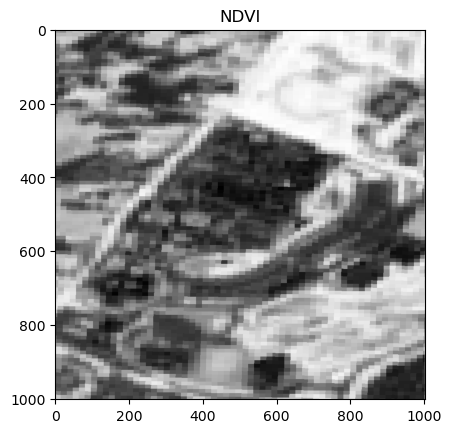

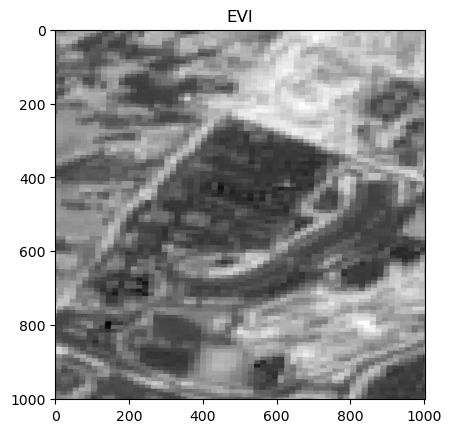

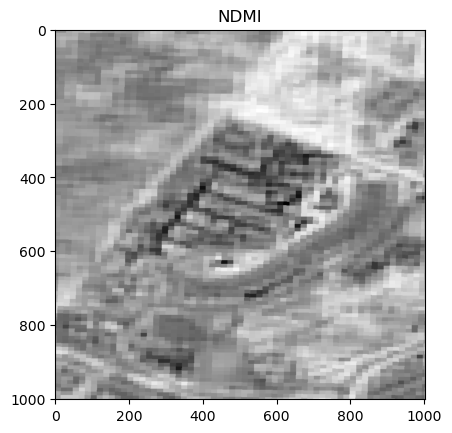

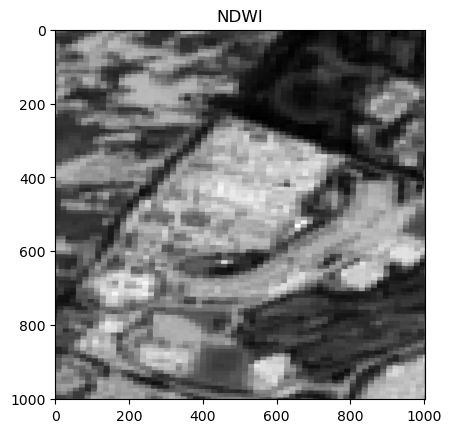

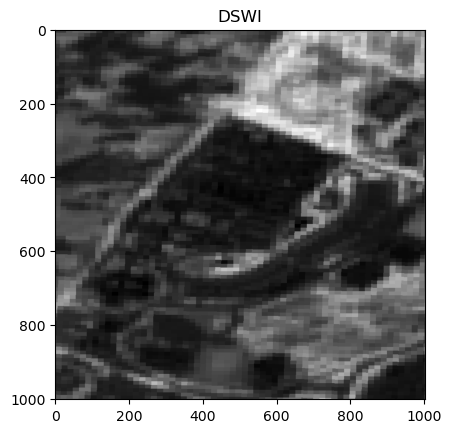

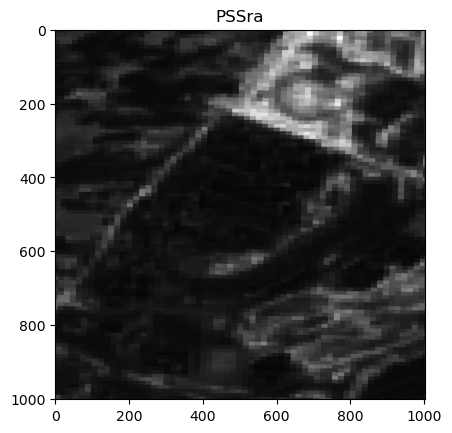

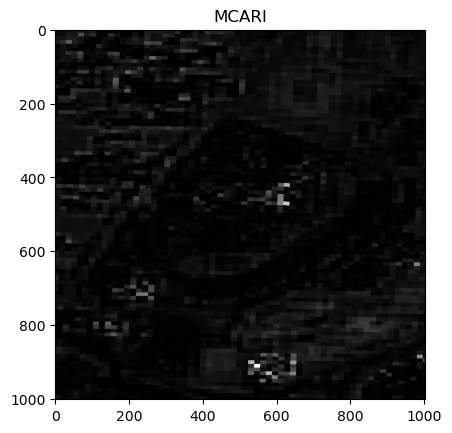

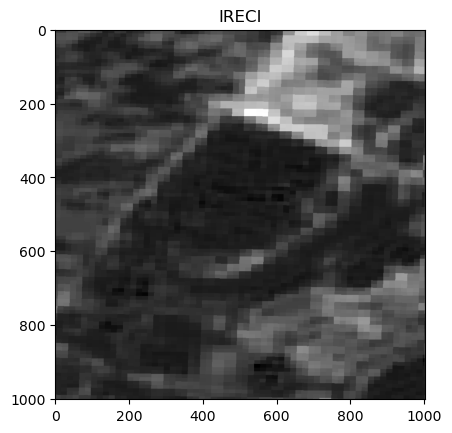

In [23]:
for _, funct in enumerate(json_object['51'].get('IMAGES_SAT')):
    plt.title(f'{funct}')
    plt.imshow(json_object['51'].get('IMAGES_SAT').get(funct), 'gray')
    plt.show()